Refer to the state of the union addresses made by US presidents since WWII. To simplify the task, only looks at the first address for each president. (You can find the archive here: https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/annual-messages-congress-the-state-the-union (Links to an external site.)) 


1. Look at the frequency of words
2. Look at topic modeling (what do they talk about)
3. 

In [180]:
# We start as always with importing the necessary libraries
import requests #PACKAGE THAT allows us download texts from online (e.g. I request Moby Dick's online book without downloading it)
import re
from requests import get
from bs4 import BeautifulSoup #Submodule of bs4 (I don't need the entire package). 
import nltk #natural language processing (NLP)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter 
from requests import get
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np
import itertools
import matplotlib.pyplot as plt
from gensim import corpora, similarities
from gensim.models import TfidfModel
from scipy.cluster import hierarchy
from nltk.stem import PorterStemmer
import pickle
import warnings
import wordninja
from selenium import webdriver
from selenium.webdriver.common.by import By
from autocorrect import Speller
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import contractions
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from scipy.cluster.vq import kmeans, vq
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import LinearSVC

#for the code to work
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/loizoskon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/loizoskon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/loizoskon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

1. Refer to the state of the union addresses made by US presidents since WWII. To simplify the task, only looks at the first address for each president. (You can find the archive here: https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/annual-messages-congress-the-state-the-union (Links to an external site.)) 

We ask BeautifulSoup to locate a table on the page, scan through the rows of this table, and then get the first link on each of the rows.

In [181]:
url = "https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/annual-messages-congress-the-state-the-union"

#https://www.presidency.ucsb.edu/documents/app-categories/spoken-addresses-and-remarks/presidential/state-the-union-addresses
#
# Find the first instance of a table on the page (this will simplify work for us)
response = get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table')

# Create an empty list to keep all the links
links = []

# Look through each row of the table to identify if there are links,
# if there are any, then get the first link, if there aren't any, just skip that row
if table.findAll("tr"):
    trs = table.findAll('tr') 
    for tr in trs:
        try:
            link = tr.find('a')['href'] # Finds the first link in a row
            links.append(link) # Appends that link to the links list.
        except:
            pass

<table border="1" cellpadding="0" cellspacing="0" class="table-responsive">
<thead>
<tr>
<td colspan="14" style="text-align: center;"><a id="Table of SOTU" name="Table of SOTU"><strong>Table of All State of the Union Messages and Addresses</strong></a></td>
</tr>
<tr>
<td style="text-align: center;"><strong><span>President</span></strong></td>
<td style="text-align: center;"><strong>Years of term</strong></td>
<td colspan="5" rowspan="1" style="text-align: center;"><strong> Delivered as a Speech (Address)</strong></td>
<td colspan="8" rowspan="1" style="text-align: center;"><strong>            Delivered as a Written Message</strong></td>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align: center; height: 16px;"> </td>
<td style="text-align: center; height: 16px;"> </td>
<td style="text-align: center; height: 16px;">1st</td>
<td style="text-align: center; height: 16px;">2nd</td>
<td style="text-align: center; height: 16px;">3rd</td>
<td style="text-align: center; height: 16px;">4th</td>


In [182]:
# We can also find all instances of the links on a page and that's what the code below does
# You can use the code below but I want to solve a more general version of the homework, 
# so I will use this code here:
############
trs= table.findAll('tr')
for tr in trs:
    try:
        aas = tr.find_all('a') # Finds the first link in a row
        for a in aas:
            link = a['href']
            links.append(link) # Appends that link to the links list.
    except:
        pass
# #
# #links
# #############
# # Note that we had to use the try: and except:,
# # because otherwise the code would result in an error as some rows don't have any links    
# # Uncomment the code below to see this for yourself.

# # Select the links that are needed
links_needed = links[0:22]

# for tr in trs:
#     link = tr.find('a')['href'] # Finds the first link in a row
#     links.append(link) # Appends that link to the links list.

In [183]:
# Links now has all the links we needed. I can save them to an excel file 
# just in case I need them

pd.DataFrame(links).to_excel("links.xlsx")

In [184]:
# We can now go through individual links and extract the information we want.
# If we examine the pages of each speech, we will notice each speech is stored inside
# the following tag "<div class="field-docs-content"> </div>". 
# That's what we can grab.

# We can also grab the date stored inside the following tag:
#  <div class="field-docs-start-date-time"></div>

# Finally, to make our life even more easy, let's grab the name of the President
# It's in the tag "<div class="field-title"></div>"

# I will also grab the title of the speech just in case I need to use it since the titles differed somewhat


# We start with creating empty containers

names = []
dates = []
speeches = []
titles = [] 

#for link in links:
#     try:
#         response = get(link)
#    except: # I need this because Nixon's speech in 1973 in done in an annoying way, it's a footnote actually
#        pass # so the code without it would result in an error
#     soup = BeautifulSoup(response.text, 'html.parser')
#     name =  soup.find("div", class_ ="field-title").get_text(strip=True)
#  #   date = soup.find("div", class_ ="field-docs-start-date-time").get_text(strip=True)
#  #   title = soup.find("div", class_ ="field-ds-doc-title").get_text(strip=True)
# #    #speech = soup.find("div", class_ ="field-docs-content").get_text(strip=True)
#     names.append(name)
#   #  dates.append(date)
#  #   titles.append(title)
#    speeches.append(speech)
    
#    print(names)

In [185]:
df = pd.DataFrame({'name': names, 'date': dates, 'title': titles, "speech": speeches})
display(df)

,name,date,title,speech


In [186]:
#df.to_excel("speeches.xlsx")
#print(date)

In [187]:
# #create a list of president names
PresidentName = ['Joseph R. Biden', 'Donald J. Trump', 'Barack Obama', 'George W. Bush',
                  'William J. Clinton', 'George Bush', 'Ronald Reagan', 'Jimmy Carter',
                  'Gerald R. Ford','Richard Nixon', 'Lyndon B. Johnson','Dwight D. Eisenhower',
                  'Harry S. Truman', 'Franklin D. Roosevelt']

# #manually extract linksof first speech of each president
link_index = [1,2,7,14,22,30,34,42,49,52,59,68,79,91]
link_index = [1,2,7,14,22,30,34,42,49,52,59,65,68,79]
newlink=[links[i] for i in link_index]

print(PresidentName)
print(newlink)
#COMMAND + SLASH

['Joseph R. Biden', 'Donald J. Trump', 'Barack Obama', 'George W. Bush', 'William J. Clinton', 'George Bush', 'Ronald Reagan', 'Jimmy Carter', 'Gerald R. Ford', 'Richard Nixon', 'Lyndon B. Johnson', 'Dwight D. Eisenhower', 'Harry S. Truman', 'Franklin D. Roosevelt']
['https://www.presidency.ucsb.edu/ws/index.php?pid=123408', 'https://www.presidency.ucsb.edu/ws/index.php?pid=102826', 'https://www.presidency.ucsb.edu/ws/index.php?pid=47232', 'https://www.presidency.ucsb.edu/ws/index.php?pid=2921', 'https://www.presidency.ucsb.edu/ws/index.php?pid=16603', 'https://www.presidency.ucsb.edu/ws/index.php?pid=29558', 'https://www.presidency.ucsb.edu/ws/index.php?pid=29542', 'https://www.presidency.ucsb.edu/documents/first-annual-message-11', 'https://www.presidency.ucsb.edu/ws/index.php?pid=29486', 'https://www.presidency.ucsb.edu/ws/index.php?pid=29475', 'https://www.presidency.ucsb.edu/ws/index.php?pid=29447', 'https://www.presidency.ucsb.edu/ws/index.php?pid=3996', 'https://www.presidency.u

In [188]:
# #create a dataframe
df = pd.DataFrame()
df['PresidentName'] = PresidentName
df['Links'] = newlink
display(df.Links.values)
print(df)

array(['https://www.presidency.ucsb.edu/ws/index.php?pid=123408',
       'https://www.presidency.ucsb.edu/ws/index.php?pid=102826',
       'https://www.presidency.ucsb.edu/ws/index.php?pid=47232',
       'https://www.presidency.ucsb.edu/ws/index.php?pid=2921',
       'https://www.presidency.ucsb.edu/ws/index.php?pid=16603',
       'https://www.presidency.ucsb.edu/ws/index.php?pid=29558',
       'https://www.presidency.ucsb.edu/ws/index.php?pid=29542',
       'https://www.presidency.ucsb.edu/documents/first-annual-message-11',
       'https://www.presidency.ucsb.edu/ws/index.php?pid=29486',
       'https://www.presidency.ucsb.edu/ws/index.php?pid=29475',
       'https://www.presidency.ucsb.edu/ws/index.php?pid=29447',
       'https://www.presidency.ucsb.edu/ws/index.php?pid=3996',
       'https://www.presidency.ucsb.edu/ws/index.php?pid=4121',
       'https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-25'],
      dtype=object)

            PresidentName                                              Links
0         Joseph R. Biden  https://www.presidency.ucsb.edu/ws/index.php?p...
1         Donald J. Trump  https://www.presidency.ucsb.edu/ws/index.php?p...
2            Barack Obama  https://www.presidency.ucsb.edu/ws/index.php?p...
3          George W. Bush  https://www.presidency.ucsb.edu/ws/index.php?p...
4      William J. Clinton  https://www.presidency.ucsb.edu/ws/index.php?p...
5             George Bush  https://www.presidency.ucsb.edu/ws/index.php?p...
6           Ronald Reagan  https://www.presidency.ucsb.edu/ws/index.php?p...
7            Jimmy Carter  https://www.presidency.ucsb.edu/documents/firs...
8          Gerald R. Ford  https://www.presidency.ucsb.edu/ws/index.php?p...
9           Richard Nixon  https://www.presidency.ucsb.edu/ws/index.php?p...
10      Lyndon B. Johnson  https://www.presidency.ucsb.edu/ws/index.php?p...
11   Dwight D. Eisenhower  https://www.presidency.ucsb.edu/ws/index.php?p...

In [189]:
outcome = []
for lnk in df.Links.values:
     r = requests.get(lnk)
     r.encoding = 'utf-8'
     html = r.text
     soup = BeautifulSoup(html,'html.parser')
     text = soup.get_text()
     outcome.append(text)
    
# print(pd.DataFrame(outcome))#all the speeches in tabular format

In [190]:
outcome1 = [x.replace("\n", "") for x in outcome]#I replace 'n' with nothing
df2 = pd.DataFrame(outcome1)#I create a new dataframe

df2[[0]]


,0
0,Address Before a Joint Session of the Congress...
1,Address Before a Joint Session of Congress on ...
2,Address Before a Joint Session of Congress on ...
3,Annual Message to the Congress on the State of...
4,Radio Address Summarizing the State of the Uni...
5,Fifth Annual Message | The American Presidency...
6,First Annual Message | The American Presidency...
7,First Annual Message | The American Presidency...
8,First Annual Message | The American Presidency...
9,Fifth Annual Message | The American Presidency...


1. What are the 10 most common "meaningful" words used by each president since Harry Truman? What does it say about the shift in priorities in the American politics? 

In [191]:
#Previous speech links were not scraped so we import the excel that includes them here for the analysis
speeches = pd.read_excel('state_of_the_union_speeches.xlsx')

#I use a function and include the code that want to apply for every president.
def my_function(x):
    r = requests.get(x['html'])
    r.encoding = 'utf-8' 
    html = r.text 
    #print(html[0:2000]) 

    soup = BeautifulSoup(html, "html.parser")
    president_text = soup.get_text()
    #print(president_text[0:2000])

    #THE DOCUMENT IS TOKENIZED -- SPLITTING TEXT INTO INDIVUDUAL WORDS
    tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(president_text) 
    #print(tokens[0:10])

    #Defining stopwords and adding more to the list. This list is same across all 14 presidents' speeches. 
    sw = nltk.corpus.stopwords.words('english') 
    newsw = ['annual', 'number', 'help', 'thank', 'get',  'going', 'think', 'look', 'said', 
             'create', 'citizens', 'citizen', 'across', 'since', 'go', 'believe', 'say', 
             'long', 'better', 'plan', 'national', 'ask' '10', 'much', 'good', 'great', 
             'best', 'cannot', 'still', 'know', 'years', '1', 'major', 'want', 'able', 'put', 
             'capacity', 'programs', 'per', 'percent', 'million', 'act', 'provide', 'afford', 
             'needed', 'may', 'possible', 'full', '2', 'effort', 'meeting', 'address', 'ever', 
             'measures', 'ago', 'delivered', '5', 'program', 'past', 'future', 'need', 'needs', 
             'house', 'also', 'tonight', 'propose', 'toward', 'continue', 'society','country', 
             'seek', 'period', 'year', 'man', 'men', 'one', 'areas', 'begin', 'live', 'make', 
             'let', 'upon', 'well', 'office', 'meet', 'make' 'citizens', 'human', 'self', 'among', 
             'peoples', 'affairs', 'would', 'field', 'first', 'interest', 'today', 'recommendations', 
             'recomenndation', 'within', 'shall', 'administration', 'nation', 'nations', 'us', 'we', 
             'policy', 'legislation', 'time', 'new', 'many', 'several', 'few', 'government', 'world', 
             'people', 'united', 'states', 'system', 'every', 'people', 'must', '626','give', 
             'categories', '226762', '17608', '24532', '430', '38','statistics', 'analyses', 
             'miscellaneous', 'congressional', 'skip', 'content', 'documents', 'attributes', 'media', 'message', 
             'congress', 'state', 'union', 'america', 'american', 'americans', 'presidency', 'president', 
             'project', 'search', 'toggle', 'navigation', 'search', 'guidebook', 'archive', 'category', 
             'main', 'take','like','yet','j','000', 'ask', '1974', 'federal', 'http', 'www', 'usb',
             'edu', 'the', 'the', 'before', 'joint', 'session', 'the','american', 'america',
            'year','congress','let','time', 'nation', 'new', 'people']
    sw.extend(newsw)
    #print(sw[0:30])

    president_words = [token.lower() for token in tokens] 
    words_ns = [word for word in president_words if word not in sw] 
    #print(words_ns[:20])
    president_ns = " ".join(words_ns)

    #Determining the most commoon words 
    count = Counter(words_ns)
    top_ten_president = count.most_common(10)
    top_10_string = ','.join([str(x) for x in top_ten_president])
    print_list = [top_10_string]
    return print_list

#for i in range(13):
# #    fun(df2)
top_list = []
for index, row in speeches.iterrows():
    top = my_function(row)
    top_list.append(top)

speeches['top ten'] = top_list

display(speeches)
print(speeches)

,president,year,party,html,top ten
0,Hoover,1929,republican,https://www.presidency.ucsb.edu/documents/annu...,"[('public', 33),('law', 25),('service', 23),('..."
1,FD_Roosvelt,1934,democrat,https://www.presidency.ucsb.edu/documents/annu...,"[('industrial', 9),('work', 8),('recovery', 7)..."
2,Truman,1949,democrat,https://www.presidency.ucsb.edu/documents/annu...,"[('prosperity', 12),('production', 12),('power..."
3,Eisenhower,1957,republican,https://www.presidency.ucsb.edu/documents/annu...,"[('free', 16),('security', 16),('economy', 12)..."
4,Kennedy,1961,democrat,https://www.presidency.ucsb.edu/documents/annu...,"[('economic', 16),('development', 10),('peace'..."
5,Lyndon,1965,democrat,https://www.presidency.ucsb.edu/documents/annu...,"[('freedom', 12),('life', 9),('progress', 8),(..."
6,Nixon,1974,republican,https://www.presidency.ucsb.edu/documents/addr...,"[('peace', 27),('energy', 17),('war', 8),('pro..."
7,Ford,1975,republican,https://www.presidency.ucsb.edu/documents/addr...,"[('energy', 25),('oil', 20),('tax', 17),('econ..."
8,Carter,1978,democrat,https://www.presidency.ucsb.edu/documents/the-...,"[('inflation', 17),('economic', 14),('tax', 13..."
9,Reagan,1985,republican,https://www.presidency.ucsb.edu/documents/addr...,"[('freedom', 20),('tax', 16),('growth', 14),('..."


      president  year       party  \
0        Hoover  1929  republican   
1   FD_Roosvelt  1934    democrat   
2        Truman  1949    democrat   
3    Eisenhower  1957  republican   
4       Kennedy  1961    democrat   
5        Lyndon  1965    democrat   
6         Nixon  1974  republican   
7          Ford  1975  republican   
8        Carter  1978    democrat   
9        Reagan  1985  republican   
10         Bush  1989  republican   
11      Clinton  1997    democrat   
12         Bush  2005  republican   
13        Obama  2013    democrat   
14        Trump  2018  republican   
15          Joe  2022    democrat   

                                                 html  \
0   https://www.presidency.ucsb.edu/documents/annu...   
1   https://www.presidency.ucsb.edu/documents/annu...   
2   https://www.presidency.ucsb.edu/documents/annu...   
3   https://www.presidency.ucsb.edu/documents/annu...   
4   https://www.presidency.ucsb.edu/documents/annu...   
5   https://www.presidency.u

## **Interpretation of all president's words since Truman**
American priorities shifted over time. As we can see, From Hoover (1929) until Nixon (1974) issues and words related to "freedom", and "peace" were emphasized. This makes sense since during that time, WW2 and the Vietnam War were fought. 

"Economy" seems like a topic that is popular in almost every presidency.

During Ford's and Reagan's presidency, "tax", and "growth" became really hot buzz words. Especially during Reagan administration, big tax reforms were introduced which they have significantly reduce taxes for businesses.

"inflation" and "energy" were also popular during Nixon, Ford, and Reagan. It is important because especially during Nixon, the US economy after 14 years of economic development got in a stagflationary state; oil and gas crisis at the 70s was also a part of that.

During George W Bush (2005), "security" was the most popular word used. This is because especially after 911, security became the main focus of his presidency.

Healthcare gained importance during the Clinton Administration, and two administrations later, the Obama Administration expanded Medicaid. With the Covid-19 pandemic, healthcare again dominated the policy priorities in Biden's 2022 address.

All the presidents, irrespective of their political affiliation (Democrats vs Republicans), mentioned about strengthening / growing the economy. Only presidents affiliated with the Democratic party seemed to emphasize on "healthcare", whereas a common theme among the Republican presidents' addresses was "war / military spending / terrorism".

Top ten words of all Democrat Presidents

In [192]:
#Previous speech links were not scraped so we import the excel that includes them here for the analysis
democrat_speeches = pd.read_excel('democrat_speeches.xlsx')

#I use a function and include the code that want to apply for every president.
def my_function(x):
    r = requests.get(x['html'])
    r.encoding = 'utf-8' 
    html = r.text 
    #print(html[0:2000]) 

    soup = BeautifulSoup(html, "html.parser")
    president_text = soup.get_text()
    #print(president_text[0:2000])

    #THE DOCUMENT IS TOKENIZED -- SPLITTING TEXT INTO INDIVUDUAL WORDS
    tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(president_text) 
    #print(tokens[0:10])

    #Defining stopwords and adding more to the list. This list is same across all 14 presidents' speeches. 
    sw = nltk.corpus.stopwords.words('english') 
    newsw = ['annual', 'number', 'help', 'thank', 'get',  'going', 'think', 'look', 'said', 
             'create', 'citizens', 'citizen', 'across', 'since', 'go', 'believe', 'say', 
             'long', 'better', 'plan', 'national', 'ask' '10', 'much', 'good', 'great', 
             'best', 'cannot', 'still', 'know', 'years', '1', 'major', 'want', 'able', 'put', 
             'capacity', 'programs', 'per', 'percent', 'million', 'act', 'provide', 'afford', 
             'needed', 'may', 'possible', 'full', '2', 'effort', 'meeting', 'address', 'ever', 
             'measures', 'ago', 'delivered', '5', 'program', 'past', 'future', 'need', 'needs', 
             'house', 'also', 'tonight', 'propose', 'toward', 'continue', 'society','country', 
             'seek', 'period', 'year', 'man', 'men', 'one', 'areas', 'begin', 'live', 'make', 
             'let', 'upon', 'well', 'office', 'meet', 'make' 'citizens', 'human', 'self', 'among', 
             'peoples', 'affairs', 'would', 'field', 'first', 'interest', 'today', 'recommendations', 
             'recomenndation', 'within', 'shall', 'administration', 'nation', 'nations', 'us', 'we', 
             'policy', 'legislation', 'time', 'new', 'many', 'several', 'few', 'government', 'world', 
             'people', 'united', 'states', 'system', 'every', 'people', 'must', '626','give', 
             'categories', '226762', '17608', '24532', '430', '38','statistics', 'analyses', 
             'miscellaneous', 'congressional', 'skip', 'content', 'documents', 'attributes', 'media', 'message', 
             'congress', 'state', 'union', 'america', 'american', 'americans', 'presidency', 'president', 
             'project', 'search', 'toggle', 'navigation', 'search', 'guidebook', 'archive', 'category', 
             'main', 'take','like','yet','j','000', 'ask', '1974', 'federal', 'http', 'www', 'usb',
             'edu', 'the', 'the', 'before', 'joint', 'session', 'the','american', 'america',
            'year','congress','let','time', 'nation', 'new', 'people']
    sw.extend(newsw)
    #print(sw[0:30])

    president_words = [token.lower() for token in tokens] 
    words_ns = [word for word in president_words if word not in sw] 
    #print(words_ns[:20])
    president_ns = " ".join(words_ns)

    #Determining the most commoon words 
    count = Counter(words_ns)
    top_ten_president = count.most_common(10)
    top_10_string = ','.join([str(x) for x in top_ten_president])
    print_list = [top_10_string]
    return print_list

#for i in range(13):
# #    fun(df2)
top_list = []
for index, row in democrat_speeches.iterrows():
    top = my_function(row)
    top_list.append(top)

democrat_speeches['top ten'] = top_list

display(democrat_speeches)


,president,year,party,html,top ten
0,FD_Roosvelt,1934,democrat,https://www.presidency.ucsb.edu/documents/annu...,"[('industrial', 9),('work', 8),('recovery', 7)..."
1,Truman,1949,democrat,https://www.presidency.ucsb.edu/documents/annu...,"[('prosperity', 12),('production', 12),('power..."
2,Kennedy,1961,democrat,https://www.presidency.ucsb.edu/documents/annu...,"[('economic', 16),('development', 10),('peace'..."
3,Lyndon,1965,democrat,https://www.presidency.ucsb.edu/documents/annu...,"[('freedom', 12),('life', 9),('progress', 8),(..."
4,Carter,1978,democrat,https://www.presidency.ucsb.edu/documents/the-...,"[('inflation', 17),('economic', 14),('tax', 13..."
5,Clinton,1997,democrat,https://www.presidency.ucsb.edu/documents/addr...,"[('children', 24),('work', 21),('budget', 17),..."
6,Obama,2013,democrat,https://www.presidency.ucsb.edu/documents/addr...,"[('jobs', 32),('work', 20),('energy', 18),('fa..."
7,Joe,2022,democrat,https://www.presidency.ucsb.edu/documents/addr...,"[('folks', 19),('see', 15),('families', 15),('..."


Top ten words of all Republican Presidents

In [193]:
#Previous speech links were not scraped so we import the excel that includes them here for the analysis
republican_speeches = pd.read_excel('republican_speeches.xlsx')

#I use a function and include the code that want to apply for every president.
def my_function(x):
    r = requests.get(x['html'])
    r.encoding = 'utf-8' 
    html = r.text 
    #print(html[0:2000]) 

    soup = BeautifulSoup(html, "html.parser")
    president_text = soup.get_text()
    #print(president_text[0:2000])

    #THE DOCUMENT IS TOKENIZED -- SPLITTING TEXT INTO INDIVUDUAL WORDS
    tokenizer = nltk.tokenize.RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(president_text) 
    #print(tokens[0:10])

    #Defining stopwords and adding more to the list. This list is same across all 14 presidents' speeches. 
    sw = nltk.corpus.stopwords.words('english') 
    newsw = ['annual', 'number', 'help', 'thank', 'get',  'going', 'think', 'look', 'said', 
             'create', 'citizens', 'citizen', 'across', 'since', 'go', 'believe', 'say', 
             'long', 'better', 'plan', 'national', 'ask' '10', 'much', 'good', 'great', 
             'best', 'cannot', 'still', 'know', 'years', '1', 'major', 'want', 'able', 'put', 
             'capacity', 'programs', 'per', 'percent', 'million', 'act', 'provide', 'afford', 
             'needed', 'may', 'possible', 'full', '2', 'effort', 'meeting', 'address', 'ever', 
             'measures', 'ago', 'delivered', '5', 'program', 'past', 'future', 'need', 'needs', 
             'house', 'also', 'tonight', 'propose', 'toward', 'continue', 'society','country', 
             'seek', 'period', 'year', 'man', 'men', 'one', 'areas', 'begin', 'live', 'make', 
             'let', 'upon', 'well', 'office', 'meet', 'make' 'citizens', 'human', 'self', 'among', 
             'peoples', 'affairs', 'would', 'field', 'first', 'interest', 'today', 'recommendations', 
             'recomenndation', 'within', 'shall', 'administration', 'nation', 'nations', 'us', 'we', 
             'policy', 'legislation', 'time', 'new', 'many', 'several', 'few', 'government', 'world', 
             'people', 'united', 'states', 'system', 'every', 'people', 'must', '626','give', 
             'categories', '226762', '17608', '24532', '430', '38','statistics', 'analyses', 
             'miscellaneous', 'congressional', 'skip', 'content', 'documents', 'attributes', 'media', 'message', 
             'congress', 'state', 'union', 'america', 'american', 'americans', 'presidency', 'president', 
             'project', 'search', 'toggle', 'navigation', 'search', 'guidebook', 'archive', 'category', 
             'main', 'take','like','yet','j','000', 'ask', '1974', 'federal', 'http', 'www', 'usb',
             'edu', 'the', 'the', 'before', 'joint', 'session', 'the','american', 'america',
            'year','congress','let','time', 'nation', 'new', 'people']
    sw.extend(newsw)
    #print(sw[0:30])

    president_words = [token.lower() for token in tokens] 
    words_ns = [word for word in president_words if word not in sw] 
    #print(words_ns[:20])
    president_ns = " ".join(words_ns)

    #Determining the most commoon words 
    count = Counter(words_ns)
    top_ten_president = count.most_common(10)
    top_10_string = ','.join([str(x) for x in top_ten_president])
    print_list = [top_10_string]
    return print_list

#for i in range(13):
# #    fun(df2)
top_list = []
for index, row in republican_speeches.iterrows():
    top = my_function(row)
    top_list.append(top)

republican_speeches['top ten'] = top_list

display(republican_speeches)

,president,year,party,html,top ten
0,Hoover,1929,republican,https://www.presidency.ucsb.edu/documents/annu...,"[('public', 33),('law', 25),('service', 23),('..."
1,Eisenhower,1957,republican,https://www.presidency.ucsb.edu/documents/annu...,"[('free', 16),('security', 16),('economy', 12)..."
2,Nixon,1974,republican,https://www.presidency.ucsb.edu/documents/addr...,"[('peace', 27),('energy', 17),('war', 8),('pro..."
3,Ford,1975,republican,https://www.presidency.ucsb.edu/documents/addr...,"[('energy', 25),('oil', 20),('tax', 17),('econ..."
4,Reagan,1985,republican,https://www.presidency.ucsb.edu/documents/addr...,"[('freedom', 20),('tax', 16),('growth', 14),('..."
5,Bush,1989,republican,https://www.presidency.ucsb.edu/documents/addr...,"[('budget', 17),('work', 12),('hope', 10),('dr..."
6,Bush,2005,republican,https://www.presidency.ucsb.edu/documents/addr...,"[('security', 29),('freedom', 20),('social', 1..."
7,Trump,2018,republican,https://www.presidency.ucsb.edu/documents/addr...,"[('tax', 15),('last', 13),('together', 13),('w..."


2. Can you conduct topic analysis of LDA using the speeches to determine what things presidents talk about in state of the union speeches?

Linear Discriminant Analysis (LDA) is like PCA, but it focuses on maximizing the seperatibility among known categories

In [194]:
type(df2.iloc[:,0])

pandas.core.series.Series

In [195]:
dataset = pd.read_excel('speeches53463.xlsx')

grouped = dataset.groupby('name')
dataset['date'] = pd.to_datetime(dataset['date'])

#print(dataset.head())
grouped = dataset.groupby('name')

dataset2 = dataset.loc[dataset.groupby('name').date.idxmin()]
#.filter(lambda x: x['date'] == min(x['date']))

In [196]:
import re
import numpy as np
    
# Print the titles of the first rows 
print(df2[[0]].head())

# Remove punctuation
dataset['title_processed'] = dataset['speech'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
dataset['title_processed'] = dataset['title_processed'].map(lambda x: x.lower())

# Print the processed titles of the first rows 
dataset['title_processed'].head()

                                                   0
0  Address Before a Joint Session of the Congress...
1  Address Before a Joint Session of Congress on ...
2  Address Before a Joint Session of Congress on ...
3  Annual Message to the Congress on the State of...
4  Radio Address Summarizing the State of the Uni...


0    the presidentthank you thank you thank you goo...
1    the presidentthank you all very very much than...
2    thank you very much mr speaker mr vice preside...
3    the presidentmr speaker mr vice president memb...
4    the presidentmadam speaker mr vice president m...
Name: title_processed, dtype: object

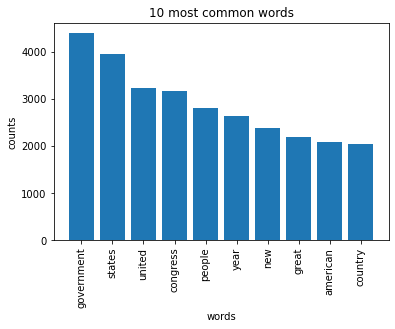

In [197]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('10 most common words')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(dataset['title_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## **Interpretation**

While the most common words do not seem to reveal something particular, when those generic words are cleaned as we saw above, we get specific topics and buzz words from each president.

In [198]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 25

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
war forces fighting men production japanese enemies peace peoples china enemy army german air germany world know armed nations united shall chinese nurses allies victory

Topic #1:
government congress world national great people public federal law shall business economic power nations nation labor present war year country men action united legislation states

Topic #2:
new people america year american years world congress government make nation americans time help work federal tax economy jobs let need security peace programs know

Topic #3:
anarchist anarchistic mckinley anarchists anarchy doctrines 1872 anna bocanegra dictator bridge haro reappropriation garfield apologizes malefactor recoined amazement imprison buren limb alleging preaching loses murder

Topic #4:
states government united congress country great public year citizens time people state treaty war present foreign subject american shall act general power nations commerce necessary


## **Interpretation**

**Topic 0**: aligns with internal state laws and political stability.

**Topic 1**: seems to align mostly with internal US issues. It is targeted to citizens stability (jobs) and needs.

**Topic 2**: Seems to be more related with tax policy and approach to the US economy.

**Topic 3**: It has to do with public policy and foreign affairs.

**Topic 4**: Mainly targeted to defence department and peace status maintenance while protecting the interests of the US.

3. Can you determine the sentiment of each state of the union using nltk's Vader module?

In [199]:
analyzer=SentimentIntensityAnalyzer()
def polarity_score(text):
    if len(text)>0:
        score=analyzer.polarity_scores(text)['compound']
        return score
    else:
        return 0
dataset['polarityscore'] = dataset['speech'].apply(lambda text : polarity_score(text))
dataset['polarityscore']

0      0.9999
1      0.9999
2      1.0000
3      0.9999
4      0.9999
        ...  
254    0.9998
255    0.9994
256    0.9995
257    0.9991
258   -0.9997
Name: polarityscore, Length: 259, dtype: float64

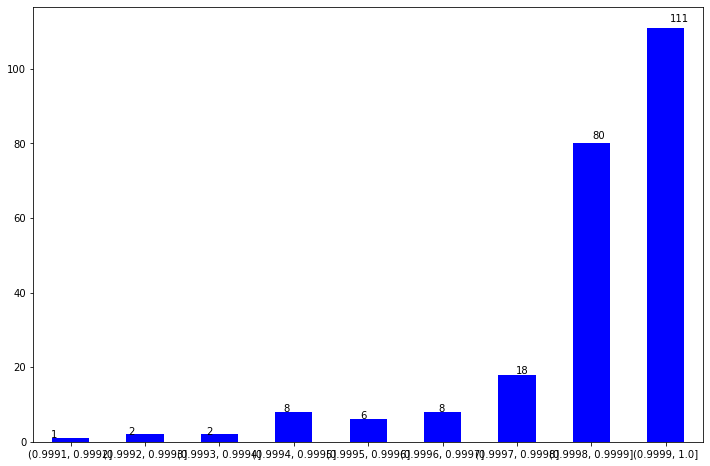

In [200]:
def sentianamolybarplot(df):
    polarity_scale=[0.9991,0.9992,0.9993,0.9994,0.9995,0.9996,0.9997,0.9998,0.9999,1]
    #'Review_polarity' is column name of sentiment score calculated for whole review.
    df3=df[(df['polarityscore']>0)]
    out = pd.cut(df3['polarityscore'],polarity_scale)
    ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(12,8))
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.040, p.get_height() * 1.015))
    plt.show()
sentianamolybarplot(dataset)

**Interpretation**

In the State of Union Speeches, the presidents talk about important issues facing Americans and offers their ideas on solving the nation's problems, including suggestions for new laws and policies. As displayed in the plot, the polarity scores for 13 speeches (barring W. Bush) is positive. This is understandable as the State of Union speeches are a PR vehicle, leveraged to display the President's power and positive influence.

4. Do speeches of different presidents cluster in any way that can allow you to determine their political party? How different are Biden and Trump according to this clustering?

In [201]:
def remove_noise(text, stop_words = nltk.corpus.stopwords.words('english')):
    newsw = ['annual', 'number', 'help', 'thank', 'get', 'going', 'think', 'look', 'said', 'create',
             'citizens', 'citizen', 'across', 'since', 'go', 'believe', 'say', 'long', 'better', 
             'plan', 'national', 'ask' '10', 'much', 'good', 'great', 'best', 'cannot', 'still', 
             'know', 'years', '1', 'major', 'want', 'able', 'put', 'capacity', 'programs', 'per', 
             'percent', 'million', 'act', 'provide', 'afford', 'needed', 'may', 'possible', 'full',
             '2', 'effort', 'meeting', 'address', 'ever', 'measures', 'ago', 'delivered', '5', 
             'program', 'past', 'future', 'need', 'needs', 'house', 'also', 'tonight', 'propose', 
             'toward', 'continue', 'society','country', 'seek', 'period', 'year', 'man', 'men', 
             'one', 'areas', 'begin', 'live', 'make', 'let', 'upon', 'well', 'office', 'meet', 
             'make' 'citizens', 'human', 'self', 'among', 'peoples', 'affairs', 'would', 'field', 
             'first', 'interest', 'today', 'recommendations', 'recomenndation', 'within', 'shall', 
             'administration', 'nation', 'nations', 'us', 'we', 'policy', 'legislation', 'time', 
             'new', 'many', 'several', 'few', 'government', 'world', 'people', 'united', 'states', 
             'system', 'every', 'people', 'must', '626','give', 'categories', '226762', '17608', 
             '24532', '430', '38','statistics', 'analyses', 'miscellaneous', 'congressional', 
             'skip', 'content', 'documents', 'attributes', 'media', 'message', 'congress', 'state',
             'union', 'america', 'american', 'americans', 'presidency', 'president', 'project', 
             'search', 'toggle', 'navigation', 'search', 'guidebook', 'archive', 'category', 'main', 
             'take','like','yet','j','000']
    stop_words = stop_words + newsw
    tokens = word_tokenize(text)
    cleaned_tokens = []
    for token in tokens:
        token = re.sub('[^A-Za-z0-9]+', '', token)
        if len(token) > 1 and token.lower() not in stop_words:
            # Get lowercase
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [202]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df = 0.8,
                                   max_features = 50,
                                   min_df = 0.1,
                                   tokenizer = remove_noise)

# Use the .fit_transform() method on the list plots
tfidf_matrix = tfidf_vectorizer.fit_transform(dataset['speech'].values)

In [203]:
num_clusters = 2

# Generate cluster centers through the kmeans function
cluster_centers, distortion = kmeans(tfidf_matrix.todense(), num_clusters)
# display(cluster_centers)
# Generate terms from the tfidf_vectorizer object
terms = tfidf_vectorizer.get_feature_names()

for i in range(num_clusters):
    print('Cluster: {}'.format(i+1))
    # Sort the terms and print top 3 terms
    center_terms = dict(zip(terms, list(cluster_centers[i])))
    sorted_terms = sorted(center_terms, key=center_terms.get, reverse=True)
    print(sorted_terms [:15])

Cluster: 1
['federal', 'economic', 'budget', 'work', 'tax', 'economy', 'security', 'jobs', 'nt', 'freedom', 'health', 'free', 'life', 'together', 'defense']
Cluster: 2
['treaty', 'subject', 'commerce', 'treasury', 'general', 'relations', 'powers', 'laws', 'duty', 'session', 'interests', 'rights', 'however', 'service', 'trade']


## **Interpretation**

On clustering the popular words in the speech, it seems like Cluster 1 aligns with speeches by Republican presidents and Cluster 2 with that of speeches by Democartic presidents.

In [204]:
#Converting the datafram into list for further analysis.
speech_list = []
for i in range(len(dataset2)):
    speech_list.append(dataset2.iloc[[i]]['speech'].item())
    
titles = []
for i in range(len(dataset2)):
    titles.append(dataset2.iloc[[i]]['name'].item())
    
texts = [txt.split() for txt in speech_list]

# Create an instance of a PorterStemmer object
porter = PorterStemmer()

# For each token of each text, we generated its stem 
texts_stem = [[porter.stem(token) for token in text] for text in texts]

# Create a dictionary from the stemmed tokens
dictionary = corpora.Dictionary(texts_stem)

# Create a bag-of-words model for each speech, using the previously generated dictionary
bows = [dictionary.doc2bow(text) for text in texts_stem]

# Generate the tf-idf model
model = TfidfModel(bows)

# Compute the similarity matrix (pairwise distance between all speeches)
sims = similarities.MatrixSimilarity(model[bows])

# Transform the resulting list into a DataFrame
sim_df = pd.DataFrame(list(sims))

# Add the name of the presidents as columns and index of the DataFrame
sim_df.columns = titles
sim_df.index = titles

# Print the resulting matrix
sim_df

,Abraham Lincoln,Andrew Jackson,Andrew Johnson,Barack Obama,Benjamin Harrison,Calvin Coolidge,Chester A. Arthur,Donald J. Trump,Dwight D. Eisenhower,Franklin D. Roosevelt,...,Rutherford B. Hayes,Theodore Roosevelt,Thomas Jefferson,Ulysses S. Grant,Warren G. Harding,William Howard Taft,William J. Clinton,William McKinley,Woodrow Wilson,Zachary Taylor
Abraham Lincoln,1.000000,0.121246,0.151205,0.047722,0.110114,0.118578,0.114825,0.047754,0.075706,0.047841,...,0.092012,0.056717,0.110742,0.124756,0.082261,0.092794,0.046491,0.113427,0.077418,0.145153
Andrew Jackson,0.121246,1.000000,0.121070,0.053532,0.131924,0.086656,0.106385,0.054705,0.077823,0.047385,...,0.112656,0.070145,0.117074,0.146622,0.092593,0.113945,0.050358,0.102445,0.086139,0.155541
Andrew Johnson,0.151205,0.121070,1.000000,0.047996,0.097058,0.094947,0.079968,0.049593,0.073742,0.053389,...,0.082619,0.077785,0.093668,0.127001,0.090346,0.077516,0.049155,0.080710,0.082443,0.092401
Barack Obama,0.047722,0.053532,0.047996,1.000000,0.046357,0.069860,0.037358,0.213163,0.103428,0.096561,...,0.035344,0.069914,0.054143,0.047495,0.073191,0.049368,0.317297,0.050867,0.064416,0.039508
Benjamin Harrison,0.110114,0.131924,0.097058,0.046357,1.000000,0.095429,0.198889,0.043727,0.082837,0.068579,...,0.269502,0.057292,0.080109,0.146124,0.080189,0.125491,0.049069,0.142834,0.076850,0.134368
Calvin Coolidge,0.118578,0.086656,0.094947,0.069860,0.095429,1.000000,0.085849,0.072170,0.118543,0.078246,...,0.081089,0.087503,0.077970,0.098388,0.128878,0.092294,0.076209,0.074285,0.086982,0.092193
Chester A. Arthur,0.114825,0.106385,0.079968,0.037358,0.198889,0.085849,1.000000,0.042525,0.058818,0.042672,...,0.144648,0.045146,0.063310,0.179516,0.066345,0.137828,0.045936,0.123470,0.059776,0.132799
Donald J. Trump,0.047754,0.054705,0.049593,0.213163,0.043727,0.072170,0.042525,1.000000,0.077175,0.062748,...,0.040511,0.077699,0.046509,0.056097,0.065570,0.040417,0.183823,0.042885,0.056082,0.040505
Dwight D. Eisenhower,0.075706,0.077823,0.073742,0.103428,0.082837,0.118543,0.058818,0.077175,1.000000,0.108428,...,0.059357,0.074973,0.060950,0.085503,0.107023,0.072974,0.128444,0.065945,0.104088,0.069061
Franklin D. Roosevelt,0.047841,0.047385,0.053389,0.096561,0.068579,0.078246,0.042672,0.062748,0.108428,1.000000,...,0.064508,0.072999,0.052945,0.059127,0.094722,0.054787,0.086663,0.063699,0.077462,0.050414


Here we can see the degree of similarity of each president's speech with each other. There is no speech with similarity more than 40%. 

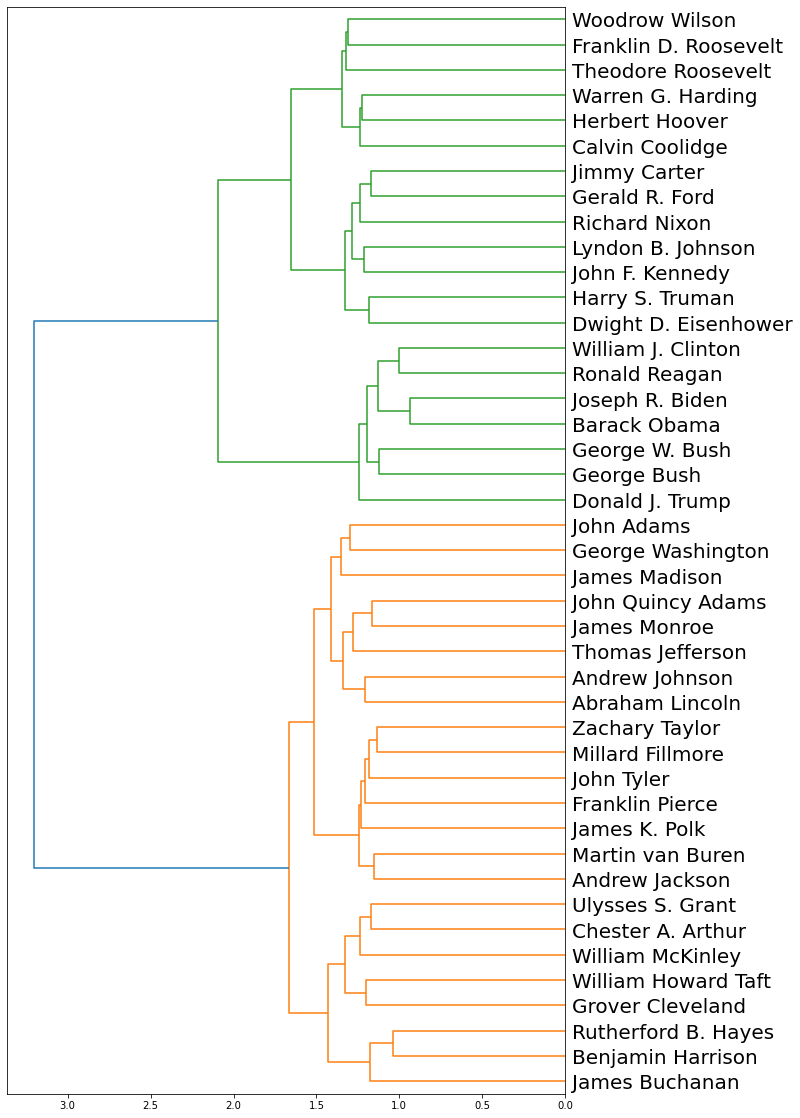

In [205]:
# Compute the clusters from the similarity matrix,
# using the Ward variance minimization algorithm
Z = hierarchy.linkage(sim_df, 'ward')
plt.rcParams['figure.figsize'] = [10,20]
# Display this result as a horizontal dendrogram
a = hierarchy.dendrogram(Z,  leaf_font_size=20, labels=sim_df.index,  orientation="left")

## **Interpretation**

In the dendrogram above, the presidents seem to be clustered based on the era that they served. Two big clusters are distinct -- the green one which includes mostly recent presidents 20th and 21st century, and -- the orange one which includes presidents of the 18th and 19th century.

5. Who was the president whose speech was the most similar to the speech of Biden in 2022?

In [206]:
v = sim_df[['Joseph R. Biden']]
v

,Joseph R. Biden
Abraham Lincoln,0.030122
Andrew Jackson,0.035307
Andrew Johnson,0.032910
Barack Obama,0.345184
Benjamin Harrison,0.028887
Calvin Coolidge,0.054890
Chester A. Arthur,0.031472
Donald J. Trump,0.220390
Dwight D. Eisenhower,0.068947
Franklin D. Roosevelt,0.053099


Text(0.5, 1.0, "Most similar to Biden's")

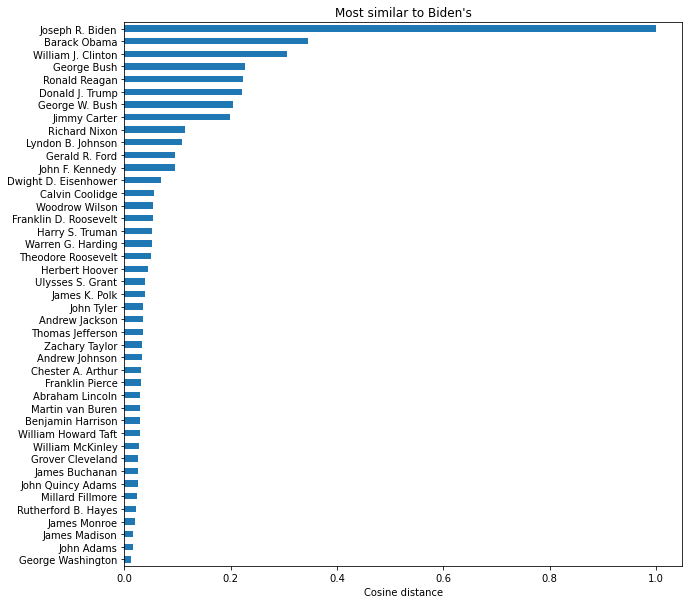

In [207]:
# This is needed to display plots in a notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,10]

# Select the column corresponding to Biden's address and 
v = sim_df['Joseph R. Biden']

# Sort by ascending scores
v_sorted = v.sort_values(ascending=True)

# Plot this data has a horizontal bar plot
v_sorted.plot.barh(x='lab', y='val', rot=0).plot()

# Modify the axes labels and plot title for better readability
plt.xlabel("Cosine distance")
plt.ylabel("")
plt.title("Most similar to Biden's")

## **Interpretation**

Biden's address is most similar to that of Obama's, follwed by Clinton and George Bush. As we can see, George Washington, John Adams and James Madison are the least similar to Biden. This can be explained by the different eras that each president lived. Speeches in 18th century are different than speeches of today. Biden's speech similarity with Obama and Clinton makes sense also because they are all recently elected democrats.

5. Bonus points: (5 points): Develop and algorithm that can allow you to determine if the speech was given by a Democrat or by a republican. 

PS2: I will go over this homework on Thursday to help you think through how to solve it. You will be able to recycle a lot of code discussed.

In [208]:
speeches

,president,year,party,html,top ten
0,Hoover,1929,republican,https://www.presidency.ucsb.edu/documents/annu...,"[('public', 33),('law', 25),('service', 23),('..."
1,FD_Roosvelt,1934,democrat,https://www.presidency.ucsb.edu/documents/annu...,"[('industrial', 9),('work', 8),('recovery', 7)..."
2,Truman,1949,democrat,https://www.presidency.ucsb.edu/documents/annu...,"[('prosperity', 12),('production', 12),('power..."
3,Eisenhower,1957,republican,https://www.presidency.ucsb.edu/documents/annu...,"[('free', 16),('security', 16),('economy', 12)..."
4,Kennedy,1961,democrat,https://www.presidency.ucsb.edu/documents/annu...,"[('economic', 16),('development', 10),('peace'..."
5,Lyndon,1965,democrat,https://www.presidency.ucsb.edu/documents/annu...,"[('freedom', 12),('life', 9),('progress', 8),(..."
6,Nixon,1974,republican,https://www.presidency.ucsb.edu/documents/addr...,"[('peace', 27),('energy', 17),('war', 8),('pro..."
7,Ford,1975,republican,https://www.presidency.ucsb.edu/documents/addr...,"[('energy', 25),('oil', 20),('tax', 17),('econ..."
8,Carter,1978,democrat,https://www.presidency.ucsb.edu/documents/the-...,"[('inflation', 17),('economic', 14),('tax', 13..."
9,Reagan,1985,republican,https://www.presidency.ucsb.edu/documents/addr...,"[('freedom', 20),('tax', 16),('growth', 14),('..."


In [209]:
df2[[0]]

,0
0,Address Before a Joint Session of the Congress...
1,Address Before a Joint Session of Congress on ...
2,Address Before a Joint Session of Congress on ...
3,Annual Message to the Congress on the State of...
4,Radio Address Summarizing the State of the Uni...
5,Fifth Annual Message | The American Presidency...
6,First Annual Message | The American Presidency...
7,First Annual Message | The American Presidency...
8,First Annual Message | The American Presidency...
9,Fifth Annual Message | The American Presidency...


In [210]:
state_speeches = pd.read_excel('state_speeches.xlsx')
state_speeches

,president,year,party,html,address
0,Hoover,1929,republican,https://www.presidency.ucsb.edu/documents/annu...,"The Constitution requires that the President ""..."
1,FD_Roosvelt,1934,democrat,https://www.presidency.ucsb.edu/documents/annu...,I COME before you at the opening of the Regula...
2,Truman,1949,democrat,https://www.presidency.ucsb.edu/documents/annu...,I am happy to report to this 81st Congress tha...
3,Eisenhower,1957,republican,https://www.presidency.ucsb.edu/documents/annu...,I appear before the Congress today to report o...
4,Kennedy,1961,democrat,https://www.presidency.ucsb.edu/documents/annu...,It is a pleasure to return from whence I came....
5,Lyndon,1965,democrat,https://www.presidency.ucsb.edu/documents/annu...,"On this Hill which was my home, I am stirred b..."
6,Nixon,1974,republican,https://www.presidency.ucsb.edu/documents/addr...,We meet here tonight at a time of great challe...
7,Ford,1975,republican,https://www.presidency.ucsb.edu/documents/addr...,"Twenty-six years ago, a freshman Congressman, ..."
8,Carter,1978,democrat,https://www.presidency.ucsb.edu/documents/the-...,Two years ago today we had the first caucus in...
9,Reagan,1985,republican,https://www.presidency.ucsb.edu/documents/addr...,I come before you to report on the state of ou...


In [211]:

# Split training and testing data
X_train, X_test, y_train, y_test = train_test_split(state_speeches['address'], state_speeches['party'], test_size=0.3, 
                 random_state=53)

# Initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words='english', 
                                   min_df=0.05, max_df=0.9)

# Create count train and test variables
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# Initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', 
                                   min_df=0.05, max_df=0.9)


# Create tfidf train and test variables
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

tfidf_nb = MultinomialNB()
tfidf_nb.fit(tfidf_train, y_train)
tfidf_nb_pred = tfidf_nb.predict(tfidf_test)
tfidf_nb_score = metrics.accuracy_score(y_test, tfidf_nb_pred)

count_nb = MultinomialNB()
count_nb.fit(count_train, y_train)
count_nb_pred = count_nb.predict(count_test)
count_nb_score = metrics.accuracy_score(y_test, count_nb_pred)

print('NaiveBayes Tfidf Score: ', tfidf_nb_score)
print('NaiveBayes Count Score: ', count_nb_score)

NaiveBayes Tfidf Score:  0.2
NaiveBayes Count Score:  0.2


In [212]:
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix


tfidf_nb_cm = metrics.confusion_matrix(y_test, tfidf_nb_pred, labels=['republican', 'democrat'])
count_nb_cm = metrics.confusion_matrix(y_test, count_nb_pred, labels=['republican', 'democrat'])

# plot_confusion_matrix(tfidf_nb_cm, classes=['republican', 'democrat'], title="TF-IDF NB Confusion Matrix")

# plot_confusion_matrix(count_nb_cm, classes=['republican', 'democrat'], title="Count NB Confusion Matrix", figure=1)

## **Interpretation**
It looks like that algorithm's power to identify whether the speech comes from a democrat or a republican is only 20%. In this case, for the algorithm to get stronger, more speeches are necessary from both sides, and maybe more text cleaning.

In [213]:
pip install jupyterthemes

Note: you may need to restart the kernel to use updated packages.


In [214]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl
